<center>
<h1>Classification of spoken digits with snnTorch</h1>
</center>

The aim of this exercise is to learn how to load and transform an event dataset of speech and develop a spiking neural network for classification of spoken digits using snnTorch.

## 1. Setup


In [1]:
import copy
import os
import pathlib
import shutil
import time
from typing import Generator, Tuple, Type, Union

import matplotlib.pyplot as plt
import snntorch as snn
import snntorch.functional
import snntorch.surrogate
import tonic
import tonic.transforms as transforms
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tonic import DiskCachedDataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm

Setup paths and configurations:

In [ ]:
# variable to indicate if the code is running on a server or locally
server = True
if server:
    data_path = pathlib.Path.home() / "nc-labs" / "data"
    data_path.mkdir(parents=True, exist_ok=True)
else:
    data_path = pathlib.Path(os.getcwd()).parent / "data" / "shd"

model_path = data_path.parent / f"model_forward_snn.pt"

%matplotlib inline

## 2. Loading Event Data with Tonic

In this section, I will explore how to load an event-based dataset using [Tonic](https://github.com/neuromorphs/tonic), a Python library that provides access to publicly available event-based vision and audio datasets, as well as event transformations. Tonic is fully compatible with snnTorch and PyTorch, making it a powerful tool for working with spiking neural networks.

The focus here is on classifying spoken digits from the [Spiking Heidelberg Digits (SHD)](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset. This dataset contains approximately 10,000 high-quality, studio-aligned recordings of spoken digits (0–9) in both German and English, recorded by 12 distinct speakers. Notably, two of these speakers are only present in the test set. Each digit is represented as spikes across 700 channels, which were generated using [Lauscher](https://github.com/electronicvisions/lauscher), a neuromorphic [cochlea](https://iopscience.iop.org/article/10.1088/2634-4386/ac4a83#nceac4a83s47) software model. The SHD dataset is accompanied by a leaderboard and is described in detail in the following paper:

Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2022).
*The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks*.
IEEE Transactions on Neural Networks and Learning Systems 33, 2744–2757.
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Recent research by Boeshertz et al. ([https://arxiv.org/abs/2407.13534](https://arxiv.org/abs/2407.13534)) has demonstrated that using adaptive LIF neurons to generate spikes from the original Heidelberg Digits data can improve both precision and data reduction. A future idea could be getting deeper into this topic by reviewing this paper and evaluating if the proposed neuron model can provide insights into why it generates better spiking data compared to the alternative used in this exercise.

### 2.1 Loading the Training Dataset and Visualizing Samples

The SHD training set contains 8,156 spoken digit samples. Each digit is represented as an array of events, where each event consists of three parameters: timestamp (t), cochlea channel number (x), and polarity (p). To better understand the dataset, the spike representations of five different samples of a single digit will be plotted.

In [3]:
dataset = tonic.datasets.SHD(save_to=data_path, train=True)
sensor_size = dataset.sensor_size
print("Sensor size (# channels):", sensor_size)
print("Number of training samples:", len(dataset))
print("Event representation: ", dataset.dtype)
print("Classes:", [c.decode('UTF-8') for c in dataset.classes])

Sensor size (# channels): (700, 1, 1)
Number of training samples: 8156
Event representation:  [('t', '<i8'), ('x', '<i8'), ('p', '<i8')]
Classes: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'null', 'eins', 'zwei', 'drei', 'vier', 'fuenf', 'sechs', 'sieben', 'acht', 'neun']


Digit 33 is represented by 5568 events
Digit 35 is represented by 8034 events
Digit 109 is represented by 5620 events
Digit 136 is represented by 5243 events
Digit 147 is represented by 6263 events


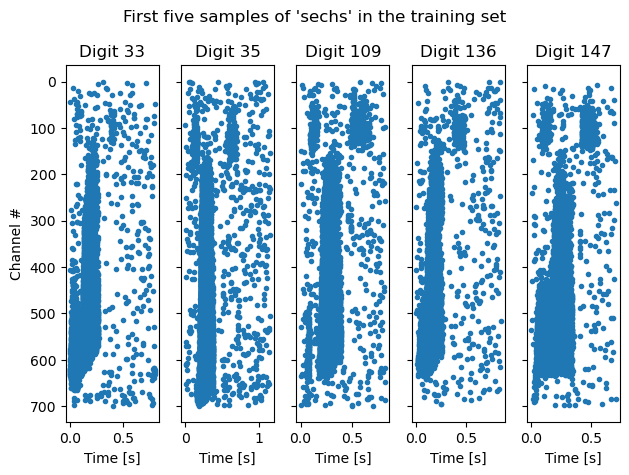

In [4]:
index = 0
samples = 0
digit = "sechs"
fig, axs = plt.subplots(1, 5, sharey=True)
fig.suptitle(f"First five samples of '{digit}' in the training set")
axs[0].set_ylabel("Channel #")
while samples < len(axs):
    events, label = dataset[index]
    if dataset.classes[label].decode('UTF-8') == digit:
        axs[samples].scatter(1e-6 * events['t'], events['x'], marker=".")
        axs[samples].invert_yaxis()
        axs[samples].set_title(f"Digit {index}")
        axs[samples].set_xlabel("Time [s]")
        print(f"Digit {index} is represented by {len(events)} events")
        samples += 1
    index += 1

plt.tight_layout()
plt.show()

Tonic provides an event plotting function that can also be used (Time in ms), which rasterizes the events and displays the result with `imshow()`.

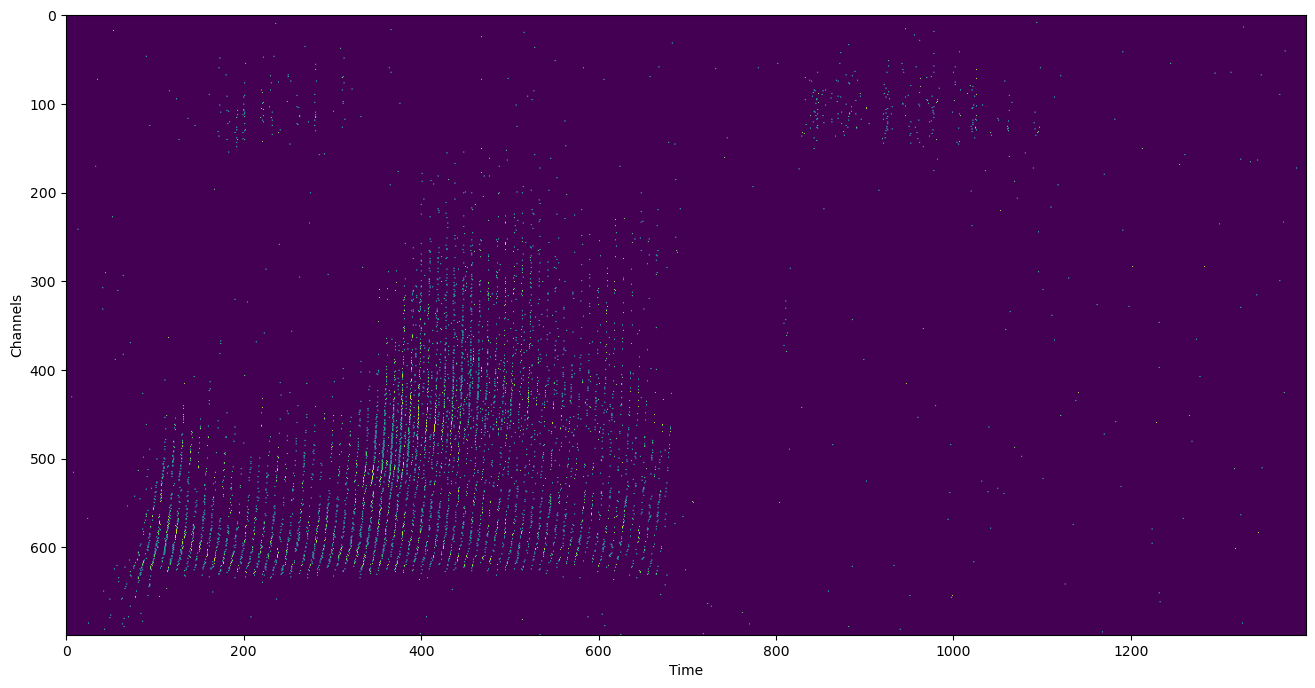

In [5]:
plt.figure(figsize=(16, 9))
tonic.utils.plot_event_grid(events)
plt.show()

#### Visualizing All Digit Classes

To gain a deeper understanding of the dataset, the next step involves implementing code to plot one sample for each of the 20 digit classes in the dataset. The resulting visualization will be a subplot with 20 panels, where each panel corresponds to one sample of a specific digit. This visualization will allow for a detailed analysis of the dataset and help address the following questions:

- Are different samples of the same digit similar or different?
- What factors contribute to the observed variations?

Number of classes: 20


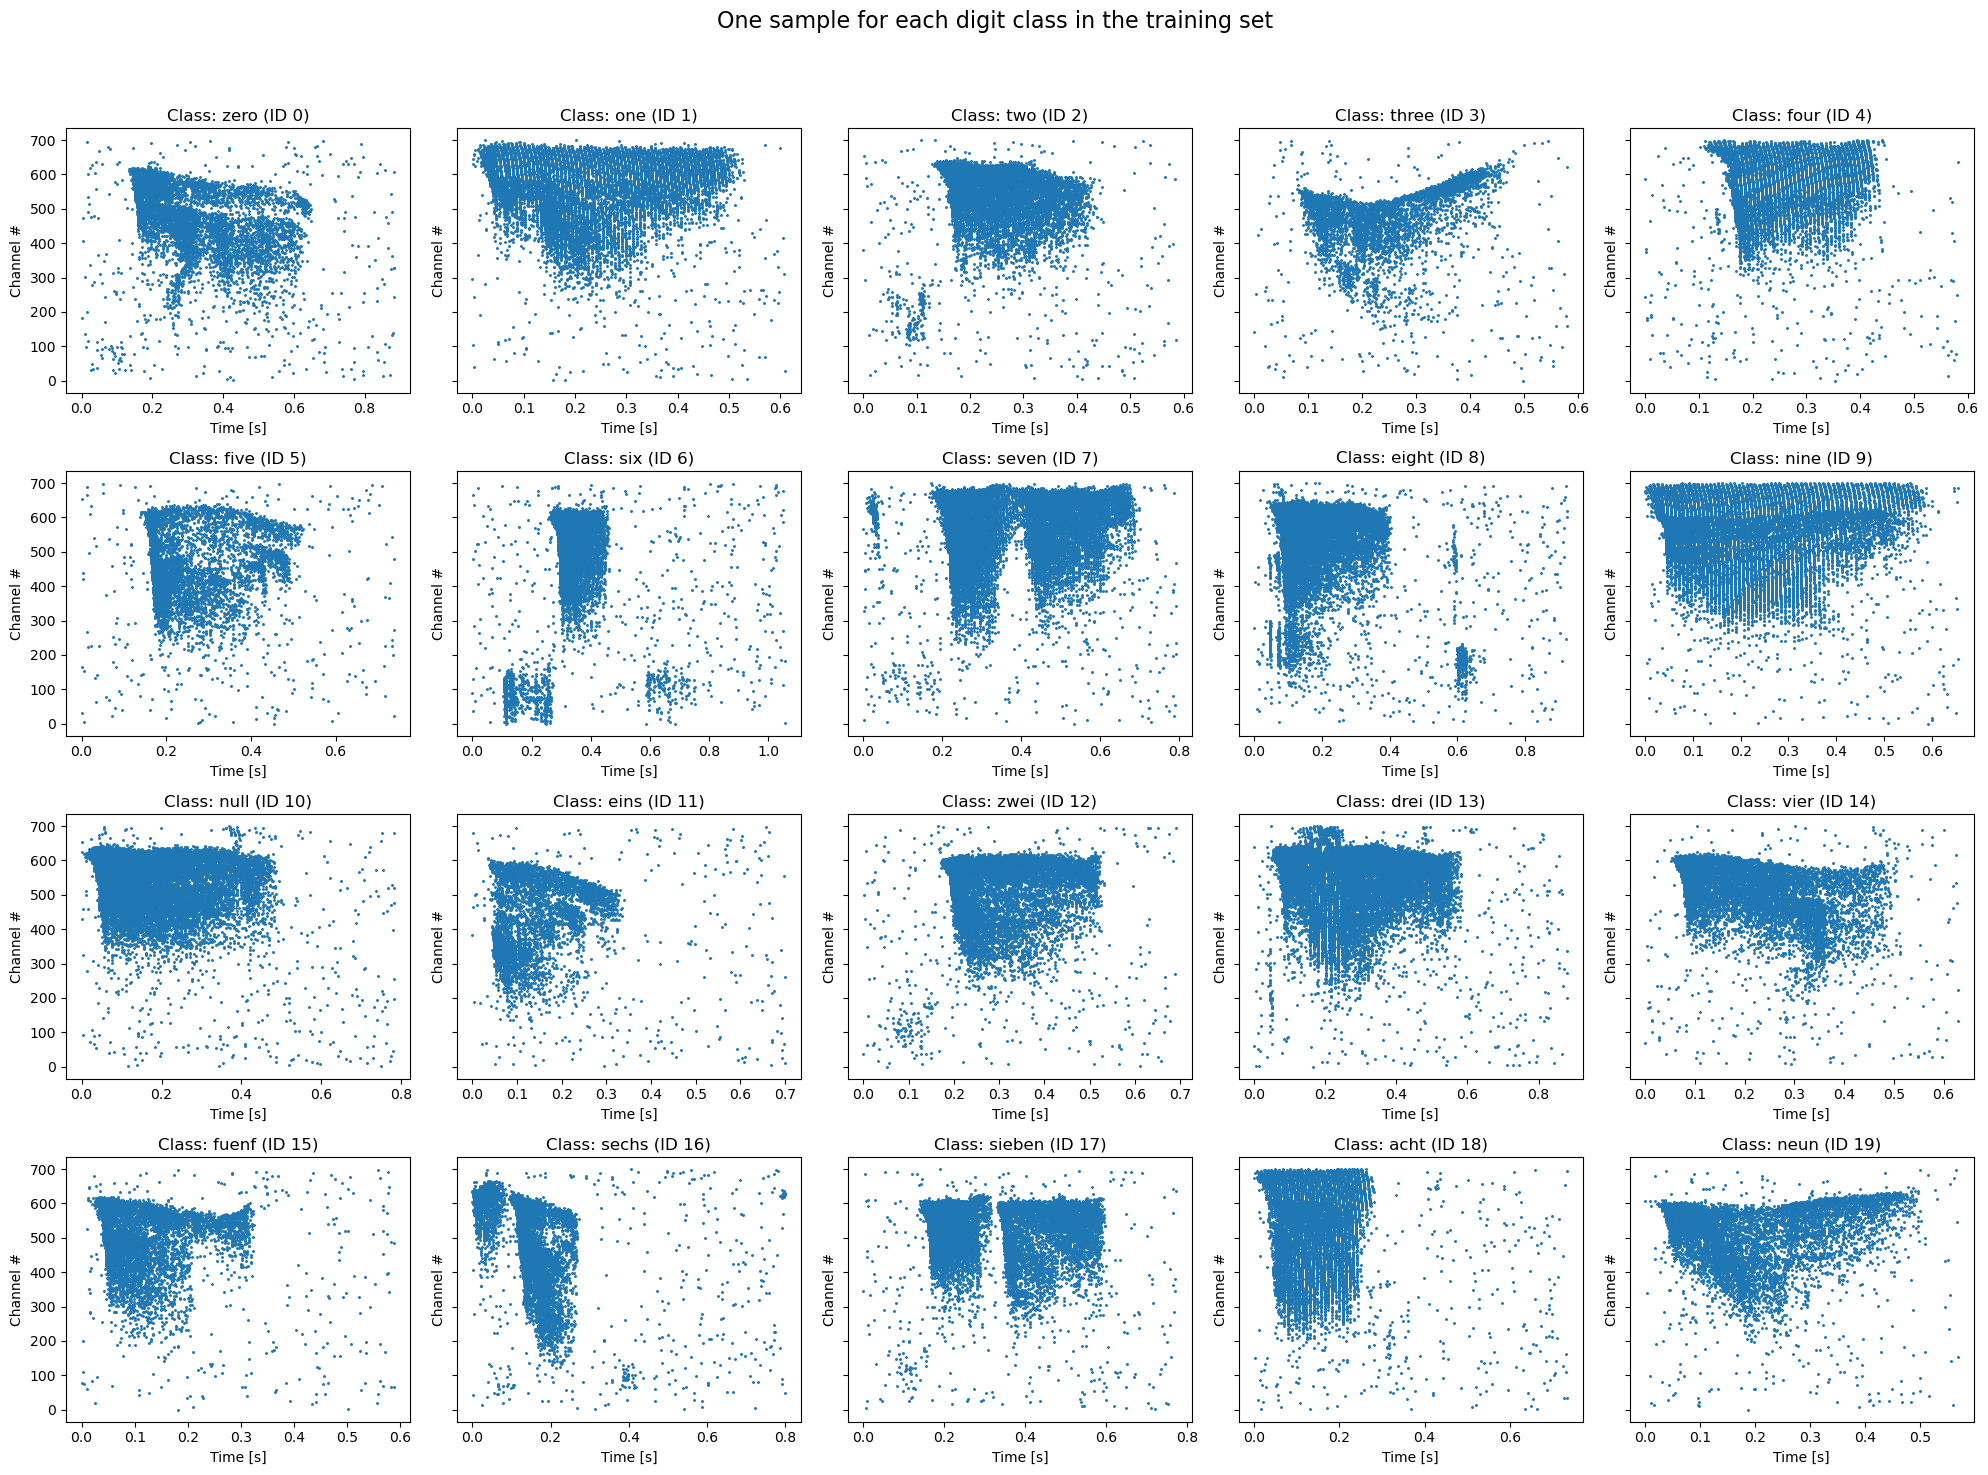

In [6]:
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharey=True)
fig.suptitle("One sample for each digit class in the training set", fontsize=16)
axs = axs.ravel()

# Plot one sample per digit class
samples_found = [False] * num_classes
index = 0

while not all(samples_found):  # Loop until all classes have a sample plotted
    events, label = dataset[index]
    class_name = dataset.classes[label].decode('UTF-8')
    if not samples_found[label]:
        axs[label].scatter(1e-6 * events['t'], events['x'], marker=".", s=5)
        axs[label].invert_yaxis()
        axs[label].set_title(f"Class: {class_name} (ID {label})")
        axs[label].set_xlabel("Time [s]")
        axs[label].set_ylabel("Channel #")
        samples_found[label] = True
    index += 1

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Are different samples of one and the same digit similar or different? Why?**

- Yes, the ones that sound similar like "zwei" and "drei" and also the same digit in English and German like "sieben" and "seven".

Additionally, considering the following key aspects of the dataset:

- **What do the different channels represent?**
  The channels represent cochlea channels. In this dataset, spikes across 700 input channels were generated using [Lauscher](https://github.com/electronicvisions/lauscher), an artificial cochlea model.

- **What is the time duration of the patterns?**
  The patterns typically span approximately 1 second.

- **Why are the patterns different even though the same digit is spoken?**
  Variations arise because different speakers may pronounce the same digit differently, and even the same speaker may produce slight variations in pronunciation across recordings.


### 2.2 Downsampling the Digits and Creating a Dataloader

With an understanding of the samples in the dataset, the next step involves preparing the digits in a format suitable for running snnTorch experiments on a PC. While achieving state-of-the-art results would require maintaining a high spatial and temporal resolution of the digits, processing the full-resolution data with 700 input channels would be computationally expensive and time-consuming. To address this, the dataset will be transformed to reduce its dimensionality while retaining essential information.

A set of transformations will be applied to the data before feeding it into a spiking neural network (SNN). Specifically:

- **Downsampling the Events:**  The [Downsample](https://tonic.readthedocs.io/en/main/autoapi/tonic/transforms/index.html#tonic.transforms.Downsample) transformation will be used to reduce the number of channels from 700 to 70. This significantly decreases the dimensionality of the resulting tensor representations, making the data more manageable for simulations.

- **Time-Binning with Frames:** The [ToFrame](https://tonic.readthedocs.io/en/main/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame) transformation will be applied to perform time-binning over 10,000 microseconds. This process converts the event data into a sequence of frames, each representing 10 milliseconds of activity across 70 channels.

To further optimize the data processing pipeline, disk caching and batching will be utilized. Once the files are loaded from the original dataset, they will be written to disk to speed up subsequent data loading. Since the event arrays have varying lengths, a collation function, `tonic.collation.PadTensors()`, will be employed to pad shorter recordings. This ensures that all tensors within a batch have consistent dimensions, enabling efficient batch processing.

In [7]:
# Keeping this small for clarity of the examples below, you may need to increase it later
batch_size = 16

cache_path = data_path.parent / "cache" / "shd" / "train"

# Delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters
# Delete the cache folder if it exists
if cache_path.exists():
    shutil.rmtree(cache_path)

time.sleep(1)

# Create the cache folder
cache_path.mkdir(parents=True, exist_ok=True)

time.sleep(1)

trainset = tonic.datasets.SHD(
    save_to=data_path,
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1),  # 70 channels
        transforms.ToFrame(sensor_size=(70, 1, 1), time_window=10000)  # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path=cache_path,
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)


# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0, 1).squeeze()
    return (events, targets)

### 2.3 Load one batch and visualize the downsampled digits 

Shape of batch with 16 digits:  torch.Size([105, 16, 70])


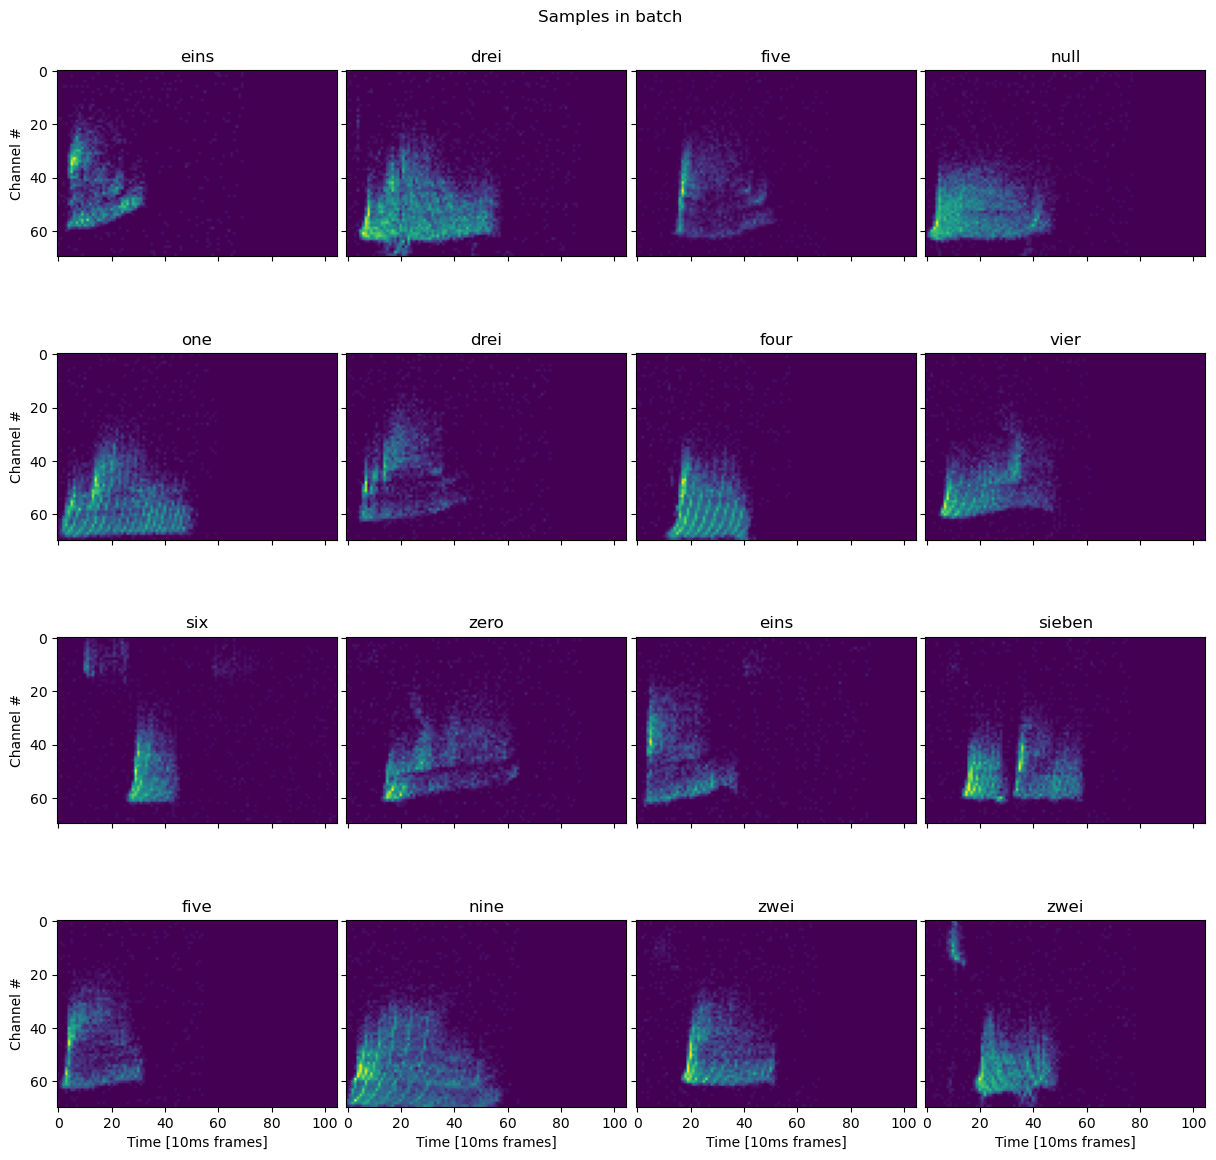

In [8]:
# Enable plotting of tensors with matplotlib
torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()
print(f"Shape of batch with {batch_size} digits: ", events.shape)

fig, axs = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle(f"Samples in batch")

for i in range(4):
    axs[i, 0].set_ylabel('Channel #')
    for j in range(4):
        index = i * 4 + j
        tensor = events[:, index, :].transpose(0, 1)
        axs[i, j].imshow(tensor)
        axs[i, j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i == 3:
            axs[i, j].set_xlabel('Time [10ms frames]')
plt.tight_layout(pad=0)
plt.show()

## 3. Processing Digits with a Feed-Forward SNN

This section presents an adaptation of the feed-forward SNN example from the snnTorch [tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html). The implementation demonstrates how a feed-forward spiking neural network (SNN) processes the downsampled digits from the SHD training set, as visualized earlier. This will not be the final SNN, but it's a good first start to understand the problem. The focus is on illustrating the following key principles:

- Running a basic SNN simulation using SHD input data.
- Visualizing the resulting spike activity in the hidden and output layers.

### 3.1 Running the SNN Simulation Over Timesteps in the Batch

The feed-forward SNN will be executed over the timesteps in the batch, processing the downsampled SHD data. This simulation provides insights into how the network handles event-based input data and generates spike activity across its layers.

To further analyze the impact of data transformations on simulation performance, the following aspects will be explored:

- **Simulation Time with Full-Resolution Data:** The simulation time for a single forward pass will be compared when using the original dataset with 700 channels versus the downsampled version with 70 channels.

- **Effect of Time-Binning:** The impact of the `toFrame` transformation, which introduces time-binning, on reducing simulation time will also be evaluated.

Simulations will be conducted to validate these analyses, providing a clear understanding of how dimensionality reduction and time-binning influence the computational efficiency of the SNN.

In [9]:
num_timesteps = events.shape[0]  # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]  # Number of digits in batch
num_channels = events.shape[2]  # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2  # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac * num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac * num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):
    cur1 = fc1(events[step, :, :])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1)  # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)  # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2)  # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([105, 16, 140])
Output spikes shape torch.Size([105, 16, 20])
Output potential shape: torch.Size([105, 16, 20])


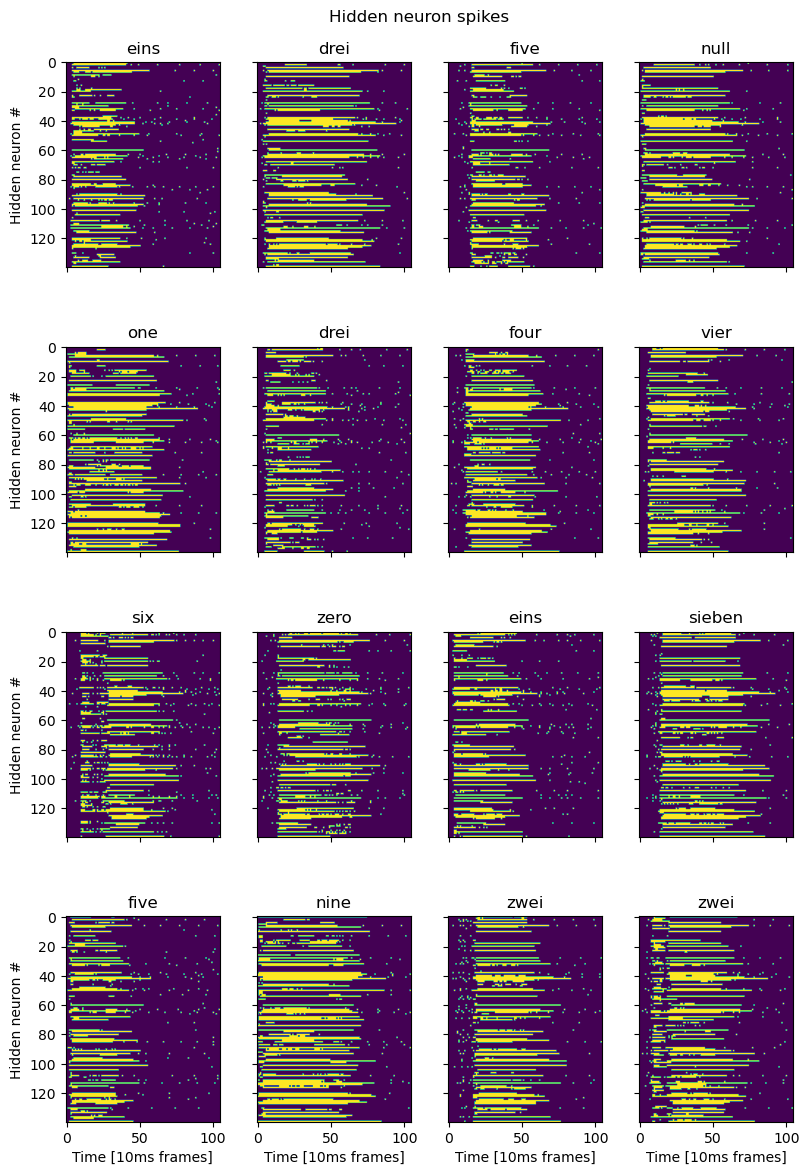

In [10]:
# Plot activity of hidden neurons for each input digit in the batch
s = spk1_rec.detach().numpy()
fig, axs = plt.subplots(4, 4, figsize=(8, 12), sharex=True, sharey=True)
fig.suptitle(f"Hidden neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i, 0].set_ylabel('Hidden neuron #')
    for j in range(4):
        index = i * 4 + j
        tensor = s[:, index, :].squeeze().transpose(1, 0)
        axs[i, j].imshow(tensor)
        axs[i, j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i == 3:
            axs[i, j].set_xlabel('Time [10ms frames]')
plt.show()

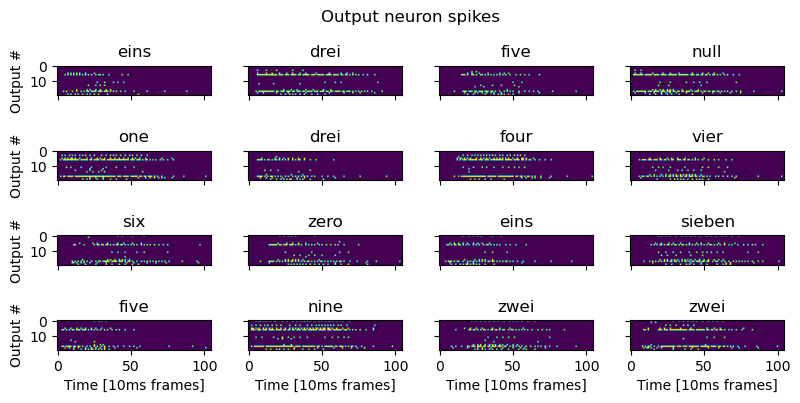

In [11]:
# Plot activity of output neurons for each input digit in the batch
s = spk2_rec.detach().numpy()
fig, axs = plt.subplots(4, 4, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"Output neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i, 0].set_ylabel('Output #')
    for j in range(4):
        index = i * 4 + j
        tensor = s[:, index, :].squeeze().transpose(1, 0)
        axs[i, j].imshow(tensor)
        axs[i, j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i == 3:
            axs[i, j].set_xlabel('Time [10ms frames]')
plt.show()

In [12]:
num_timesteps = events.shape[0]  # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]  # Number of digits in batch
num_channels = events.shape[2]  # Number of channels in downsampled digits
num_classes = len(trainset.classes)

print(
    f"Number of timesteps: {num_timesteps} \nNumber of samples: {num_samples} \n"
    f"Number of channels: {num_channels} \nNumber of classes: {num_classes}"
)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2  # Size of hidden layer in relation to size of input layer


class ForwardSNN(nn.Module):
    def __init__(self, beta: float, num_inputs: int, hidden_sizefac: int, num_channels: int, num_timesteps: int,
                 num_outputs: int):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, hidden_sizefac * num_channels)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hidden_sizefac * num_channels, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        self.num_timesteps = num_timesteps

    def forward(self, x) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record for outputs
        spk1_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_timesteps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


forward_snn = ForwardSNN(beta=beta, num_inputs=num_inputs, hidden_sizefac=hidden_sizefac, num_channels=num_channels,
                         num_timesteps=num_timesteps, num_outputs=num_outputs)

Number of timesteps: 105 
Number of samples: 16 
Number of channels: 70 
Number of classes: 20


Run SNN forward pass with the downsampled digits

In [13]:
events, target = load_training_batch()

In [14]:
result = %timeit -n 1 -r 10 -o _ = forward_snn(events)

285 ms ± 45.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [15]:
print(f"Average time per forward pass: {result.average:.2f} s")

Average time per forward pass: 0.28 s


Run SNN forward pass with the original number of channels

In [16]:
_dataset = tonic.datasets.SHD(
    save_to=data_path,
    train=True,
    transform=transforms.Compose([
        transforms.ToFrame(sensor_size=(700, 1, 1), time_window=10000),  # us to 10 ms
        torch.from_numpy
    ])
)

_trainloader = DataLoader(
    _dataset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors(),
)

original_events, original_labels = next(iter(_trainloader))
original_events = original_events.transpose(0, 1).squeeze()

original_forward_snn = ForwardSNN(beta=beta, num_inputs=700, hidden_sizefac=hidden_sizefac, num_channels=700,
                                  num_timesteps=original_events.shape[0], num_outputs=num_outputs)

In [17]:
origin_result = %timeit -n 1 -r 10 -o _ = original_forward_snn(original_events)
print(f"Average time per forward pass: {origin_result.average:.2f} s")

1.02 s ± 206 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Average time per forward pass: 1.02 s


In [18]:
print(
    f"Simulation time with downsampled digits is {origin_result.average / result.average:.1f} times faster than with the original number of channels.")

Simulation time with downsampled digits is 3.6 times faster than with the original number of channels.


### 3.2 Simulation Time Analysis

The simulation time for a single forward pass was analyzed to understand the computational impact of using the original dataset with 700 channels compared to the downsampled version with 70 channels. Simulations reveal that:

- Using the original 700 channels increases the simulation time by approximately 10 times on standard laptops.
- On the LTU server, the simulation time is approximately 4 times longer with 700 channels compared to the downsampled version.

This analysis highlights the significant computational benefits of dimensionality reduction and the importance of optimizing input data for efficient SNN simulations.


## 4. Training an SNN to Classify Digits

This section focuses on developing and training a feed-forward spiking neural network (SNN) to classify the 20 different digits in the SHD dataset. The implementation builds on the concepts introduced earlier and leverages insights from the [snnTorch tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html), along with other relevant snnTorch functions.

### Objective

The goal is to train the SNN such that the 20 output neurons of the network can differentiate between the 20 digit classes in the SHD dataset. After training, the network should exhibit the following behavior:

- For each target class, one specific output neuron should be more likely to fire and/or fire with a higher spike rate compared to the other 19 neurons.

### Key Considerations

Unlike the MNIST dataset used in tutorial 5, where samples have fixed dimensionality and can be flattened into vectors, the SHD digits have varying durations in time. This requires the network to account for temporal dynamics and optimize the response of the output neurons over time as each digit is presented. The implementation will address this challenge by designing the network to process time-varying input data effectively.

### Deliverables

The following outputs will be generated to evaluate the performance of the trained SNN:

1. **Loss Curve:**
   A plot of the loss curve from the start to the end of training (over all epochs). The loss should decrease and eventually converge or fluctuate at a low value, indicating successful training.

2. **Classifier Accuracy:**
   The accuracy of the classifier will be measured both before and after training. This will provide insights into the improvement achieved through training.

3. **Confusion Matrix:**
   A confusion matrix will be plotted to visualize the classifier's performance across all digit classes. The matrix will help identify the strengths and weaknesses of the classifier based on the results.

### Implementation

The implementation begins with defining utility functions to support the training and evaluation process:

In [19]:
# Keeping this small for clarity of the examples below, you may need to increase it later
batch_size = 128

cache_path = data_path.parent / "cache" / "shd" / "train"

# Delete the cache folder if it exists
if cache_path.exists():
    shutil.rmtree(cache_path)

time.sleep(1)

# Create the cache folder
cache_path.mkdir(parents=True, exist_ok=True)

time.sleep(1)


def get_data_loader(data_path: pathlib.Path, train: bool = True, batch_size: int = 16,
                    validation_split: float = None) -> Union[DataLoader, Tuple[DataLoader, DataLoader]]:
    """ Load the SHD dataset and return a DataLoader with the specified batch size.
    
    Args:
        data_path (pathlib.Path): Path to the SHD dataset.
        train (bool): Whether to load the training set or not.
        batch_size (int): Batch size.
        
    Returns:
        DataLoader: DataLoader with the SHD dataset.
    """
    dataset = tonic.datasets.SHD(
        save_to=str(data_path),
        train=train,
        transform=transforms.Compose([
            transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1),  # 70 channels
            # 116 fixed number of frame, approx 10 ms per frame based in previous tries
            transforms.ToFrame(sensor_size=(70, 1, 1), n_event_bins=116)
        ])
    )

    if validation_split:
        # Calculate the number of samples for training and validation
        num_samples = len(dataset)
        num_val = int(num_samples * validation_split)
        num_train = num_samples - num_val

        # Split the dataset into training and validation subsets
        train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

        # Create data loaders for training and validation subsets
        return DataLoader(
            train_dataset,
            batch_size=batch_size,
            collate_fn=tonic.collation.PadTensors(batch_first=False)
        ), DataLoader(
            val_dataset,
            batch_size=batch_size,
            collate_fn=tonic.collation.PadTensors(batch_first=False)
        )

    else:
        cached_trainset = DiskCachedDataset(
            dataset,
            cache_path=cache_path,
            transform=torch.from_numpy
        )

        return DataLoader(
            cached_trainset,
            batch_size=batch_size,
            collate_fn=tonic.collation.PadTensors(batch_first=False)
        )

The `ForwardSNN` class implements a feed-forward Spiking Neural Network (SNN) designed for time-series data, such as the SHD dataset. It leverages spiking neuron dynamics and PyTorch's modular framework to process event-based data efficiently. Here's a breakdown of its key components and functionality:

### **Key Components**

1. **Network Architecture:**
   - The network consists of three fully connected layers (`fc1`, `fc2`, `fc3`), each followed by a spiking neuron layer (`lif1`, `lif2`, `lif3`) using Leaky Integrate-and-Fire (LIF) dynamics.
   - The `beta` parameter controls the decay rate of the LIF neurons, simulating the temporal dynamics of spiking activity.
   - The final layer (`lif3`) is configured to output spikes, which are used for classification.

2. **Temporal Processing:**
   - The network processes input data over a specified number of timesteps (`num_timesteps`), simulating the temporal evolution of spikes and membrane potentials.

3. **Loss and Optimization:**
   - A customizable loss function (`loss_function`) is used to compute the error between the network's output and the target labels.
   - The optimizer (`optimizer`) updates the network's parameters during training, with optional keyword arguments (`opt_kwargs`) for fine-tuning.

### **Key Methods**

1. **`forward`:**
   - Simulates the network's behavior over time by iterating through the timesteps.
   - At each timestep, the input is passed through the fully connected layers and LIF neurons, updating the membrane potentials and generating spikes.
   - Records the spike activity (`spk_rec`) and membrane potentials (`mem_rec`) for all timesteps.

2. **`evaluate`:**
   - Computes the spike count over all timesteps and evaluates the network's performance using the loss function and accuracy metric.
   - The accuracy is calculated using the `snntorch.functional.accuracy_rate` function.

3. **`trainin_step`:**
   - Executes a single training step by evaluating the loss and accuracy, performing backpropagation, and updating the network's parameters using the optimizer.
   - Gradients are cleared after each update to prepare for the next step.

4. **`valid_or_test_step`:**
   - Evaluates the network's performance on validation or test data without performing parameter updates.

### **Highlights**

- **Temporal Dynamics:** The network processes data over multiple timesteps, capturing the temporal structure of event-based inputs.
- **Spiking Neurons:** The use of LIF neurons introduces biologically inspired spiking behavior, making the network suitable for neuromorphic applications.
- **Customizability:** The architecture, loss function, optimizer, and learning rate can be easily adjusted to suit different datasets and tasks.
- **Training and Evaluation:** The class provides a clear separation between training, validation, and testing steps, ensuring modularity and ease of use.

In [20]:
class ForwardSNN(nn.Module):
    def __init__(
        self,
        beta: float,
        num_inputs: int,
        hidden_size: int,
        num_timesteps: int,
        num_outputs: int,
        lr: float,
        loss_function: Type[snn.functional.LossFunctions],
        optimizer: Type[torch.optim.Optimizer],
        opt_kwargs: dict = None
    ):
        super().__init__()

        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(hidden_size, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, output=True)
        self.num_timesteps = num_timesteps
        self.loss_function = loss_function()
        self.optimizer = optimizer(self.parameters(), lr=lr, **opt_kwargs)

    def forward(self, x) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record for outputs
        spk_rec = []
        mem_rec = []

        for step in range(self.num_timesteps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc2(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk_rec.append(spk3)
            mem_rec.append(mem3)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> (nn.Module, float):
        # Spike count
        X, _ = self(X)
        X = X.squeeze().sum(0)
        loss = self.loss_function(X, y)
        acc = snntorch.functional.accuracy_rate(spk_out=X, targets=y, num_classes=False)

        return loss, acc

    def trainin_step(self, X: torch.Tensor, y: torch.Tensor) -> (float, float):
        loss, acc = self.evaluate(X=X, y=y)

        # Backpropagation
        loss.backward()

        # Update parameters
        self.optimizer.step()

        # Clear gradients
        self.optimizer.zero_grad()

        return loss.item(), acc

    def valid_or_test_step(self, X: torch.Tensor, y: torch.Tensor) -> (float, float):
        loss, acc = self.evaluate(X=X, y=y)
        return loss.item(), acc


Defining variables

Loading data:

In [21]:
train_loader, val_loader = get_data_loader(
    data_path=data_path,
    train=True,
    batch_size=batch_size,
    validation_split=0.2
)

The training loop for the feed-forward SNN incorporates several advanced techniques to ensure efficient and robust training:

1. **Early Stopping Mechanism:** This monitors the validation loss during training and halts the process if the loss does not improve for a predefined number of epochs (patience). This prevents overfitting and saves computational resources by stopping training when further improvements are unlikely.

2. **Pocket Algorithm:** The pocket algorithm ensures that the best-performing model (based on validation accuracy or loss) is saved during training. Even if the model overfits or degrades in later epochs, the best version is retained for evaluation and deployment.

3. **Scheduled Learning Rate:** A learning rate scheduler is used to adjust the learning rate dynamically during training. For example, the learning rate may decrease after a certain number of epochs or when the validation loss plateaus. This helps the model converge more effectively by taking larger steps initially and smaller steps as it approaches the optimal solution.

4. **Weight Decay:** Weight decay (L2 regularization) is applied to the model's weights to prevent overfitting by penalizing large weight values. This encourages the network to learn simpler, more generalizable patterns in the data.

In [24]:
# Train SNN classifier
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Number of channels in downsampled digits
num_channels = 70
num_classes = len(dataset.classes)
num_epochs = 30
# Number of epochs to wait for improvement before stopping
early_stopping_patience = 5

# network
net = ForwardSNN(
    beta=0.95,
    num_inputs=num_channels,
    hidden_size=512,
    num_timesteps=30,
    num_outputs=num_classes,
    loss_function=snntorch.functional.ce_count_loss,
    optimizer=torch.optim.Adam, opt_kwargs={"betas": (0.875, 0.95), "weight_decay": 0.1},
    lr=3e-4
)
net.to(device)
scheduler = StepLR(net.optimizer, step_size=10, gamma=0.1)

dtype = torch.float32
n_train_batches = len(iter(train_loader))
n_val_batches = len(val_loader)

# Initialize the best model parameters and best validation accuracy
best_model_params = copy.deepcopy(net.state_dict())
best_val_acc = 0.0
epochs_since_improvement = 0

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_acc = 0
    val_loss = 0
    train_batch = iter(train_loader)
    val_batch = iter(val_loader)

    # Minibatch training loop
    with tqdm(total=n_train_batches + n_val_batches, desc=f"Epoch {epoch}", unit=" batches", leave=True, position=0) as pbar:
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass and optimization
            net.train()
            loss, acc = net.trainin_step(X=data, y=targets)

            train_loss += loss
            train_acc += acc

            # Update progress bar for batches
            pbar.update(1)
            pbar.set_postfix(train_loss=loss)

        # Record average train accuracy and loss per epoch
        epoch_train_loss = train_loss / n_train_batches
        epoch_train_acc = train_acc / n_train_batches
        train_acc_hist.append(epoch_train_acc)
        train_loss_hist.append(epoch_train_loss)

        with torch.no_grad():
            for data, targets in val_batch:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass and optimization
                net.eval()
                _loss, _acc = net.valid_or_test_step(X=data, y=targets)

                val_loss += _loss
                val_acc += _acc

                # Update progress bar for batches
                pbar.update(1)
                pbar.set_postfix(train_loss=epoch_train_loss, train_acc=epoch_train_acc, val_loss=_loss)

        # Record average validation accuracy and loss per epoch
        epoch_val_loss = val_loss / n_val_batches
        epoch_val_acc = val_acc / n_val_batches
        val_acc_hist.append(epoch_val_acc)
        val_loss_hist.append(epoch_val_loss)
        pbar.update(0)
        pbar.set_postfix(train_loss=epoch_train_loss, train_acc=epoch_train_acc, val_loss=epoch_val_loss, val_acc=epoch_val_acc)

        # Update the best model parameters if the current validation accuracy is better
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_params = copy.deepcopy(net.state_dict())
            # Reset the counter if there is an improvement
            epochs_since_improvement = 0
        else:
            # Increment the counter if there is no improvement
            epochs_since_improvement += 1

    # Step scheduler
    scheduler.step()

    # Check for early stopping
    if epochs_since_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Device: cuda


Epoch 29: 100%|██████████| 64/64 [00:48<00:00,  1.32 batches/s, train_acc=0.974, train_loss=0.092, val_acc=0.882, val_loss=0.653]

Early stopping triggered after 30 epochs.


In [25]:
# Load the best model parameters
net.load_state_dict(best_model_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")

Best validation accuracy: 0.8845


Loss Curve:

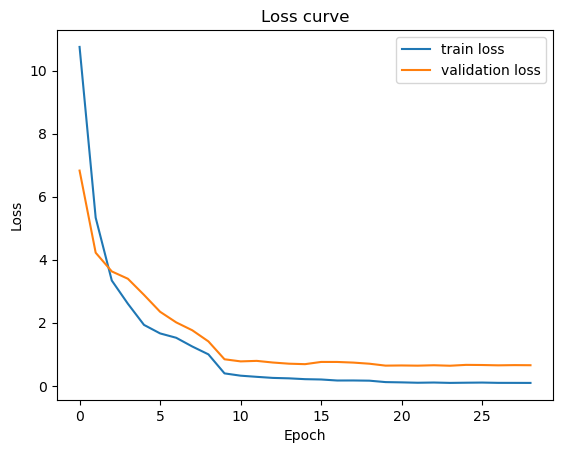

In [26]:
# Plot loss curve
plt.plot(range(len(train_loss_hist) - 1), train_loss_hist[1:], label="train loss")
plt.plot(range(len(val_loss_hist) - 1), val_loss_hist[1:], label="validation loss")
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Train Accuracy over epoch

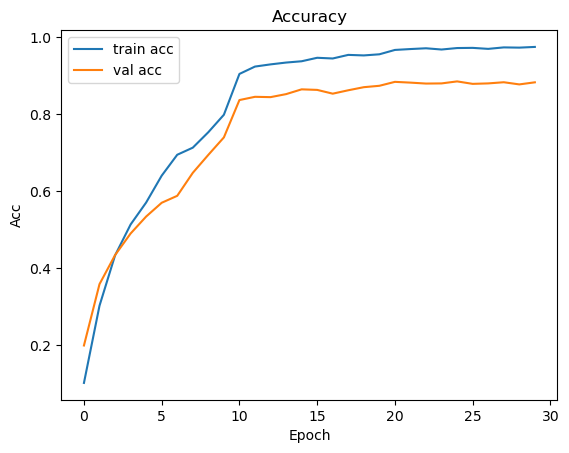

In [32]:
# Plot loss curve
plt.plot(range(len(train_acc_hist)), train_acc_hist, label="train acc")
plt.plot(range(len(val_acc_hist)), val_acc_hist, label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [28]:
import numpy


def measure_accuracy(model: torch.nn.Module, data_iter: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
                     num_samples: int) -> (float, list, list):
    preds_rec = []
    targets_rec = []

    acc_hist = []

    with torch.no_grad(), tqdm(total=num_samples, desc="Evaluating", unit=" batches", leave=True, position=0) as pbar:
        model.eval()

        for data, targets in data_iter:
            data = data.to(device).squeeze()
            targets = targets.to(device)

            _, eval_acc = net.valid_or_test_step(X=data, y=targets)

            spk_rec, _ = net(data)
            spk_rec = spk_rec.sum(0)
            preds = spk_rec.sum(0).argmax(1).cpu().numpy()
            targets = targets.cpu().numpy()

            assert len(preds) == len(targets), f"Length of predictions is {len(preds)} and of targets is {len(targets)}"

            preds_rec.extend(preds)
            targets_rec.extend(targets)

            acc_hist.append(eval_acc)

            # Update progress bar for batches
            pbar.update(1)
            pbar.set_postfix(batch_acc=eval_acc)

    accuracy = numpy.mean(acc_hist).item()

    return accuracy, preds_rec, targets_rec

In [31]:
# free up space in GPU
# del trainloader
# torch.cuda.empty_cache()

testloader = get_data_loader(data_path=data_path, train=False, batch_size=batch_size)
# test_batch = create_batch_generator(testloader)
test_batch = iter(testloader)
test_accuracy, preds_rec, targets_rec = measure_accuracy(model=net, data_iter=test_batch, num_samples=len(testloader))
print(f"\n\nTest Accuracy: {test_accuracy:.4f}\n\n")
print("Saving model...")
torch.save(net.state_dict(), model_path)

Evaluating: 100%|██████████| 18/18 [00:10<00:00,  1.67 batches/s, batch_acc=0.614]



Test Accuracy: 0.6704


Saving model...


Confusion Matrix:

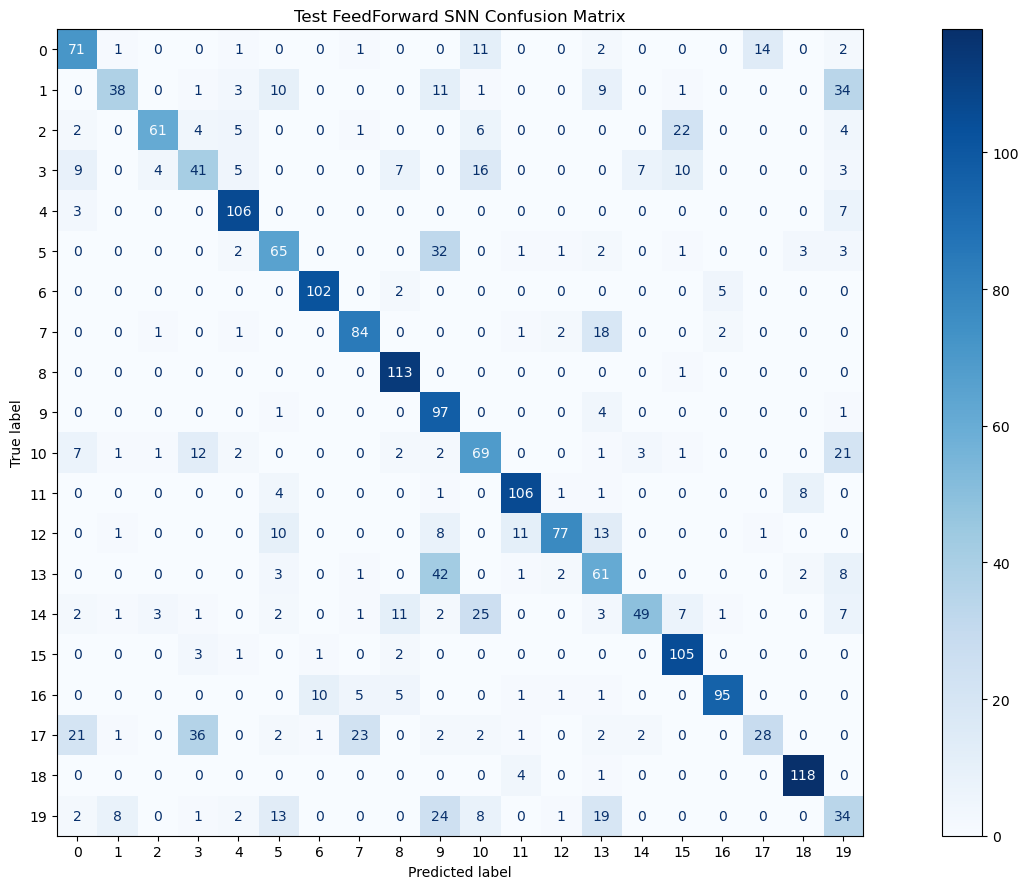

In [30]:
def plot_confusion_matrix(y_true: numpy.ndarray, y_pred: numpy.ndarray, num_classes: int, title: str = ""):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
    cm = confusion_matrix(y_pred=y_pred, y_true=y_true, labels=range(num_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true=targets_rec, y_pred=preds_rec, num_classes=num_classes, title="Test FeedForward SNN")

## References

The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks;
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-Based Optimization to Spiking Neural Networks; [https://doi.org/10.1109/MSP.2019.2931595](https://doi.org/10.1109/MSP.2019.2931595).

Training Spiking Neural Networks Using Lessons From Deep Learning; [https://doi.org/10.1109/JPROC.2023.3308088](https://doi.org/10.1109/JPROC.2023.3308088).